<a href="https://colab.research.google.com/github/hyogyeong/ESAA/blob/main/SVM_%EC%BA%90%EA%B8%80_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing librairies

import pandas as pd 
import numpy as np

# Scikit-learn library: For SVM
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm

import itertools

# Matplotlib library to plot the charts
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Library for the statistic data vizualisation
import seaborn

%matplotlib inline

# Data recuperation

In [8]:
data = pd.read_csv('creditcard.csv') # Reading the file .csv
df = pd.DataFrame(data) # Converting data to Panda DataFrame

# Data Visualization

In [9]:
df = pd.DataFrame(data) # Converting data to Panda DataFrame

In [10]:
df.describe() # Description of statistic features (Sum, Average, Variance, minimum, 1st quartile, 2nd quartile, 3rd Quartile and Maximum)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


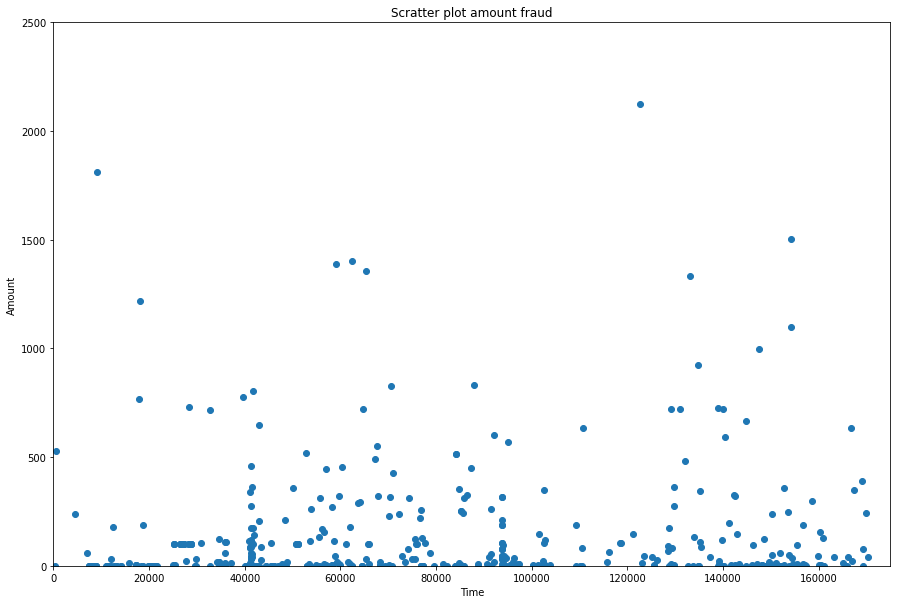

In [11]:
df_fraud = df[df['Class'] == 1] # Recovery of fraud data
plt.figure(figsize=(15,10))
plt.scatter(df_fraud['Time'], df_fraud['Amount']) # Display fraud amounts according to their time
plt.title('Scratter plot amount fraud')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.xlim([0,175000])
plt.ylim([0,2500])
plt.show()

We notive, first of all, the time doesn't impact the frequency of frauds. Moreover, the majority of frauds are small amounts.

In [12]:
nb_big_fraud = df_fraud[df_fraud['Amount'] > 1000].shape[0] # Recovery of frauds over 1000
print('There are only '+ str(nb_big_fraud) + ' frauds where the amount was bigger than 1000 over ' + str(df_fraud.shape[0]) + ' frauds')

There are only 9 frauds where the amount was bigger than 1000 over 492 frauds


Unbalanced data

In [13]:
number_fraud = len(data[data.Class == 1])
number_no_fraud = len(data[data.Class == 0])
print('There are only '+ str(number_fraud) + ' frauds in the original dataset, even though there are ' + str(number_no_fraud) +' no frauds in the dataset.')

There are only 492 frauds in the original dataset, even though there are 284315 no frauds in the dataset.


This dataset is unbalanced which means using the data as it is might result in unwanted behaviour from a supervised classifier. To make it easy to understand if a classifier were to train with this data set trying to achieve the best accuracy possible it would most likely label every transaction as a non-fraud

In [14]:
print("The accuracy of the classifier then would be : "+ str((284315-492)/284315)+ " which is the number of good classification over the number of tuple to classify")

The accuracy of the classifier then would be : 0.998269524998681 which is the number of good classification over the number of tuple to classify


To answer this problem we could use the oversampling principle or the undersampling principle The undersampling principle should be used only if we can be sure that the selected few tuples (in this case non-fraud) are representative of the whole non-fraud transactions of the dataset.

# Correlation of features

In [15]:
df_corr = df.corr() # Calculation of the correlation coefficients in pairs, with the default method:
                    # Pearson, Standard Correlation Coefficient

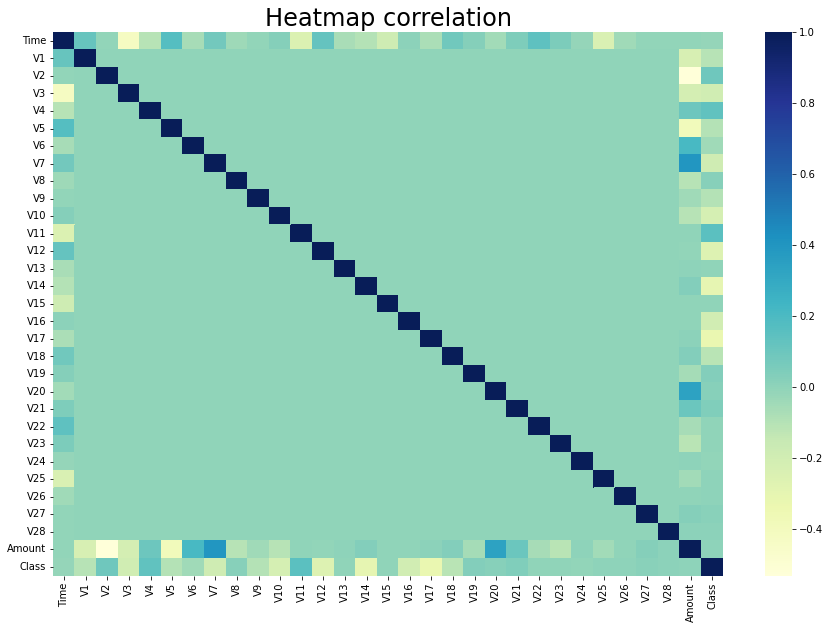

In [16]:
plt.figure(figsize=(15,10))
seaborn.heatmap(df_corr, cmap="YlGnBu") # Displaying the Heatmap
seaborn.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

As we can notice, most of the features are not correlated with each other. This corroborates the fact that a PCA was previously performed on the data.

What can generally be done on a massive dataset is a dimension reduction. By picking th emost important dimensions, there is a possiblity of explaining most of the problem, thus gaining a considerable amount of time while preventing the accuracy to drop too much.

However in this case given the fact that a PCA was previously performed, if the dimension reduction is effective then the PCA wasn't computed in the most effective way. Another way to put it is that no dimension reduction should be computed on a dataset on which a PCA was computed correctly.

In [17]:
rank = df_corr['Class'] # Retrieving the correlation coefficients per feature in relation to the feature class
df_rank = pd.DataFrame(rank) 
df_rank = np.abs(df_rank).sort_values(by='Class',ascending=False) # Ranking the absolute values of the coefficients
                                                                  # in descending order
df_rank.dropna(inplace=True) # Removing Missing Data (not a number)

#Data Selection

OVERSAMPLING

One way to do oversampling is to replicate the under-represented class tuples until we attain a correct proportion between the class

However as we haven't infinite time nor the patience, we are going to run the classifier with the undersampled training data (for those using the undersampling principle if results are really bad just rerun the training dataset definition)

UNDERSAMPLING

In [18]:
# We seperate ours data in two groups : a train dataset and a test dataset

# First we build our train dataset
df_train_all = df[0:150000] # We cut in two the original dataset
df_train_1 = df_train_all[df_train_all['Class'] == 1] # We seperate the data which are the frauds and the no frauds
df_train_0 = df_train_all[df_train_all['Class'] == 0]
print('In this dataset, we have ' + str(len(df_train_1)) +" frauds so we need to take a similar number of non-fraud")

df_sample=df_train_0.sample(300)
df_train = df_train_1.append(df_sample) # We gather the frauds with the no frauds. 
df_train = df_train.sample(frac=1) # Then we mix our dataset

In this dataset, we have 293 frauds so we need to take a similar number of non-fraud


In [19]:
X_train = df_train.drop(['Time', 'Class'],axis=1) # We drop the features Time (useless), and the Class (label)
y_train = df_train['Class'] # We create our label
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [20]:
############################## with all the test dataset to see if the model learn correctly ##################
df_test_all = df[150000:]

X_test_all = df_test_all.drop(['Time', 'Class'],axis=1)
y_test_all = df_test_all['Class']
X_test_all = np.asarray(X_test_all)
y_test_all = np.asarray(y_test_all)

Then we define training and testing set after applying a dimension reduction to illustrate the fact that nothing will be gained because a PCA was previously computed

In [21]:
X_train_rank = df_train[df_rank.index[1:11]] # We take the first ten ranked features
X_train_rank = np.asarray(X_train_rank)

In [22]:
############################## with all the test dataset to see if the model learn correctly ##################
X_test_all_rank = df_test_all[df_rank.index[1:11]]
X_test_all_rank = np.asarray(X_test_all_rank)
y_test_all = np.asarray(y_test_all)

# Confusion Matrix

In [23]:
class_names=np.array(['0','1']) # Binary label, Class = 1 (fraud) and Class = 0 (no fraud)

In [24]:
# Function to plot the confusion Matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Model Selection

So now, we'll use a SVM model classifier, with the scikit-learn library.

In [25]:
classifier = svm.SVC(kernel='linear') # We set a SVM classifier, the default SVM Classifier (Kernel = Radial Basis Function)

In [26]:
classifier.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Testing the model

In [27]:
prediction_SVM_all = classifier.predict(X_test_all) #And finally, we predict our data test.

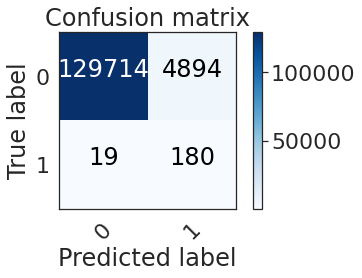

In [28]:
cm = confusion_matrix(y_test_all, prediction_SVM_all)
plot_confusion_matrix(cm,class_names)

In this case we are gonna try to minimize the number of errors in our prediction results. Errors are on the anti-diagonal of the confusion matrix. But we can infer that being wrong about an actual fraud is far worse than being wrong about a non-fraud transaction.

That is why using the accuracy as only classification criterion could be considered unthoughtful. During the remaining part of this study our criterion will consider precision on the real fraud 4 times more important than the general accuracy. Even though the final tested result is accuracy.

In [29]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9163291514505774


In [30]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 180 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.9045226130653267
the accuracy is : 0.9635553049915806


# Models Rank

There is a need to compute the fit method again, as the dimension of the tuples to predict went from 29 to 10 because of the dimension reduction

In [31]:
classifier.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier.predict(X_test_all_rank) #And finally, we predict our data test.

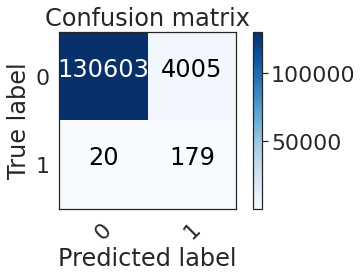

In [32]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)

print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

In [33]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 179 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.8994974874371859
the accuracy is : 0.9701425000185451


We can see that the study using the reduced data is far from unrelevant, which means that the last step of the previously computed PCA could have been done in a more efficient way. Indeed one of the main question we have with the PCA once we calculated the principals components direction, is how many of this component are we gonna keep. This means that some of the 30 dimensions are do not discriminate classes that much.

# Re-balanced class weigh 

In this previously used SVM model, the weigh of each class was the same, which means that missing a fraud is as bad as misjudging a non-fraud. The objective, for a bank, is to maximize the number of detected frauds! Even if it means considering more non-fraud tuple as fraudulent operation. So, we need to minimize the False positives : the number of no detected frauds.

Indeed, by modifying the class_weight parameter, we can chose which class to give more importance during the training phase. In this case, the class_1 which describes the fraudulent operations will be considered more important than the class_0 (non-fraud operation). However, in this case we will give more importance to the class_0 due to the large number of misclassed non-fraud operation. Of course the goal is to lose as little effective fraud as possible in the process.

In [34]:
classifier_b = svm.SVC(kernel='linear',class_weight={0:0.60, 1:0.40})

In [35]:
classifier_b.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 0.6, 1: 0.4},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

# Testing the model

In [36]:
prediction_SVM_b_all = classifier_b.predict(X_test_all) #We predict all the data set.

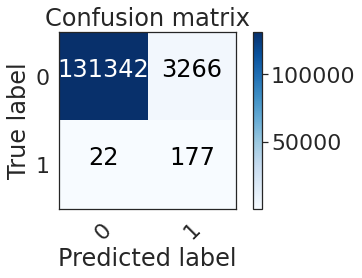

In [37]:
cm = confusion_matrix(y_test_all, prediction_SVM_b_all)
plot_confusion_matrix(cm,class_names)

In [38]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9066797039788094


In [39]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 177 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.8894472361809045
the accuracy is : 0.9756095751704288


#Models Rank

In [40]:
classifier_b.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier_b.predict(X_test_all_rank) #And finally, we predict our data test.

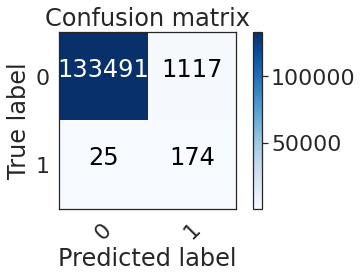

In [41]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)


In [42]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.8978032134009712


In [43]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 174 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.8743718592964824
the accuracy is : 0.9915286298189263
